<a href="https://colab.research.google.com/github/shadab4150/Classify-the-components-of-handwritten-Bengali/blob/master/Grapheme_Bengali_Letter_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/CSV files/train grapheme.zip' -d '/content/train/'

In [0]:
import pandas as pd
import numpy as np
from pathlib import Path
import fastai
from fastai.vision import *
from fastai.callbacks import TrackerCallback, SaveModelCallback
import os
import warnings
warnings.filterwarnings("ignore")

In [0]:
path = Path('/content/')

In [6]:
path.ls()

[PosixPath('/content/.config'),
 PosixPath('/content/train'),
 PosixPath('/content/drive'),
 PosixPath('/content/.ipynb_checkpoints'),
 PosixPath('/content/sample_data')]

In [0]:
sz = 128
bs = 128
fold = 0
SEED = 2245
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [137]:
df = pd.read_csv('/content/train_gra.csv')
df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [0]:
def root(x):
  ans='grapheme_root_'+str(x)
  return ans
def vowel(x):
  ans='volwel_diacritic_'+str(x)
  return ans
def conso(x):
  ans='consonant_diacritic_'+str(x)
  return ans



In [0]:
df['grapheme_root']=df.grapheme_root.apply(root,convert_dtype=True)
df['vowel_diacritic']=df.vowel_diacritic.apply(vowel,convert_dtype=True)
df['consonant_diacritic']=df.consonant_diacritic.apply(conso,convert_dtype=True)

In [29]:
df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,grapheme_root_15,volwel_diacritic_9,consonant_diacritic_5,ক্ট্রো
1,Train_1,grapheme_root_159,volwel_diacritic_0,consonant_diacritic_0,হ
2,Train_2,grapheme_root_22,volwel_diacritic_3,consonant_diacritic_5,খ্রী
3,Train_3,grapheme_root_53,volwel_diacritic_2,consonant_diacritic_2,র্টি
4,Train_4,grapheme_root_71,volwel_diacritic_9,consonant_diacritic_5,থ্রো


In [143]:
len(df.grapheme_root.unique())

168

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

(0, 100)

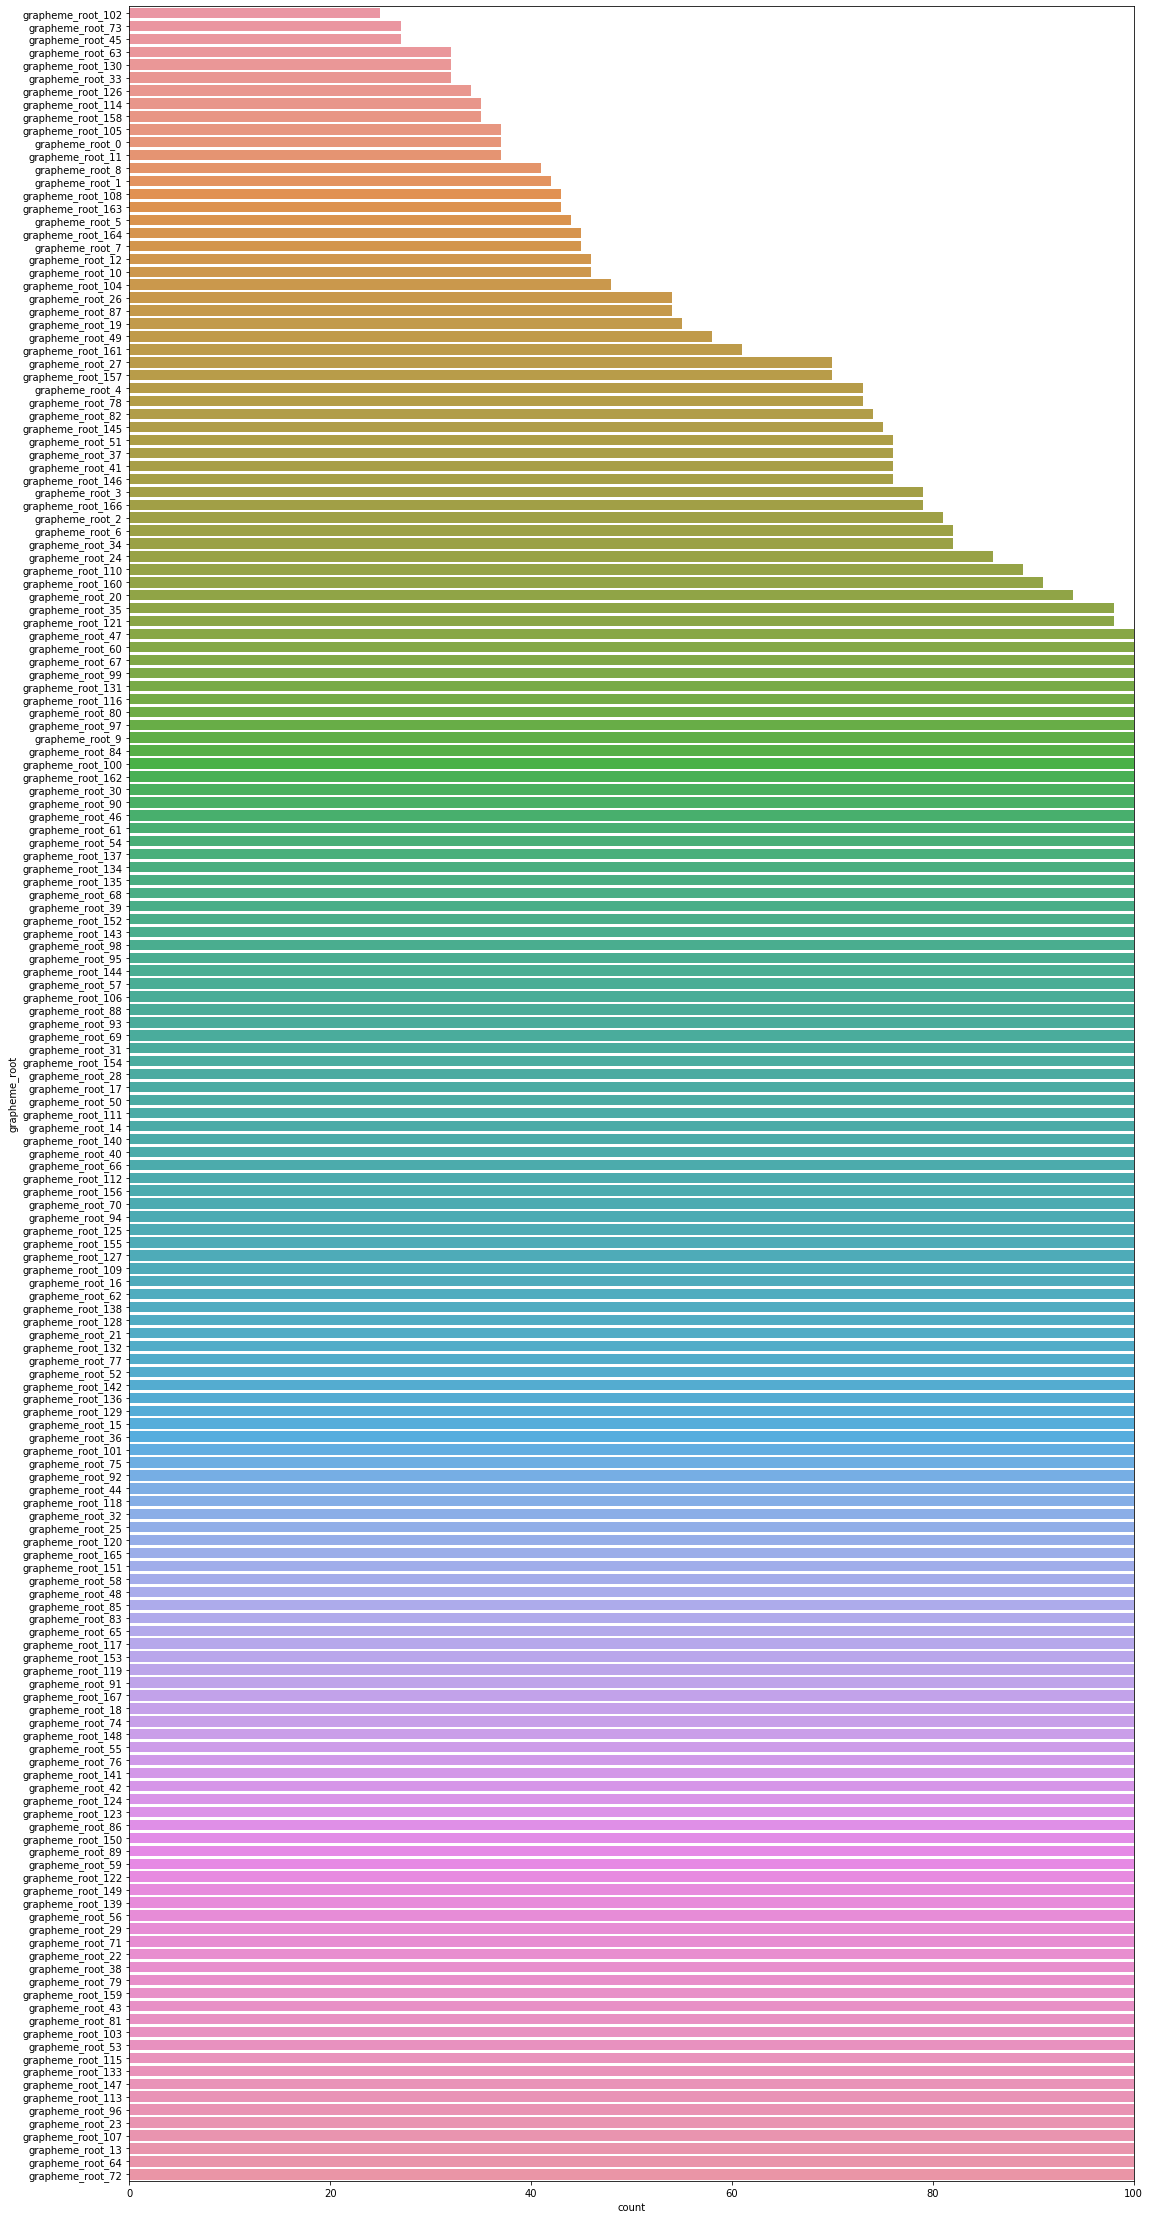

In [174]:
plt.figure(1,figsize=(18,40))
sns.countplot(y='grapheme_root',data=df,order=df['grapheme_root'].value_counts().sort_values().index)
plt.xlim(0,100)

In [175]:
x=df['grapheme_root'].value_counts().sort_values().index
y=df['grapheme_root'].value_counts().sort_values().values
graph=pd.DataFrame({'grapheme_root':x,'values':y})
graph.head(10)

,grapheme_root,values
0,grapheme_root_102,25
1,grapheme_root_73,27
2,grapheme_root_45,27
3,grapheme_root_63,32
4,grapheme_root_130,32
5,grapheme_root_33,32
6,grapheme_root_126,34
7,grapheme_root_114,35
8,grapheme_root_158,35
9,grapheme_root_105,37


In [180]:
graph[graph['values']<70]

,grapheme_root,values
0,grapheme_root_102,25
1,grapheme_root_73,27
2,grapheme_root_45,27
3,grapheme_root_63,32
4,grapheme_root_130,32
5,grapheme_root_33,32
6,grapheme_root_126,34
7,grapheme_root_114,35
8,grapheme_root_158,35
9,grapheme_root_105,37


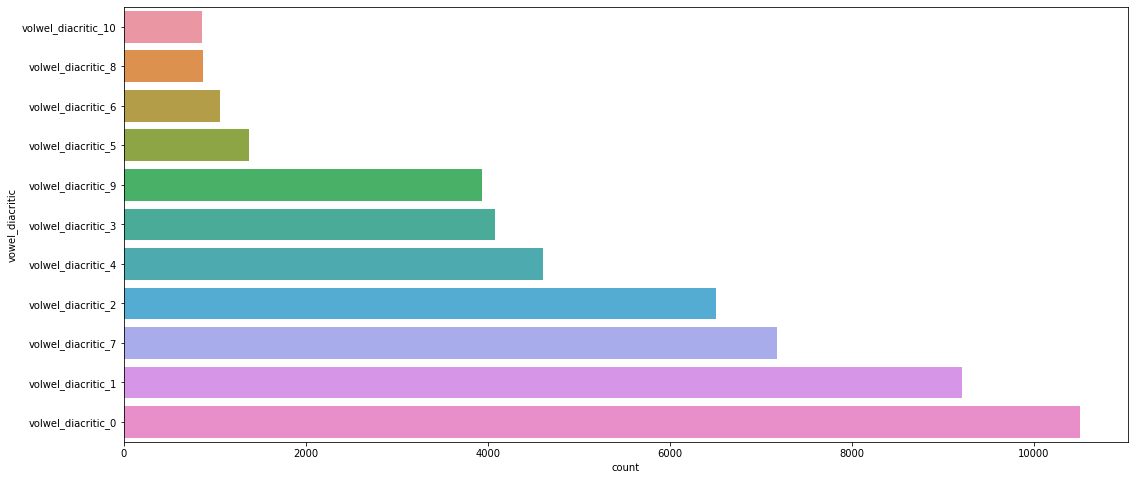

In [172]:
plt.figure(1,figsize=(18,8))
sns.countplot(y='vowel_diacritic',data=df,order=df['vowel_diacritic'].value_counts().sort_values().index)

(0, 400)

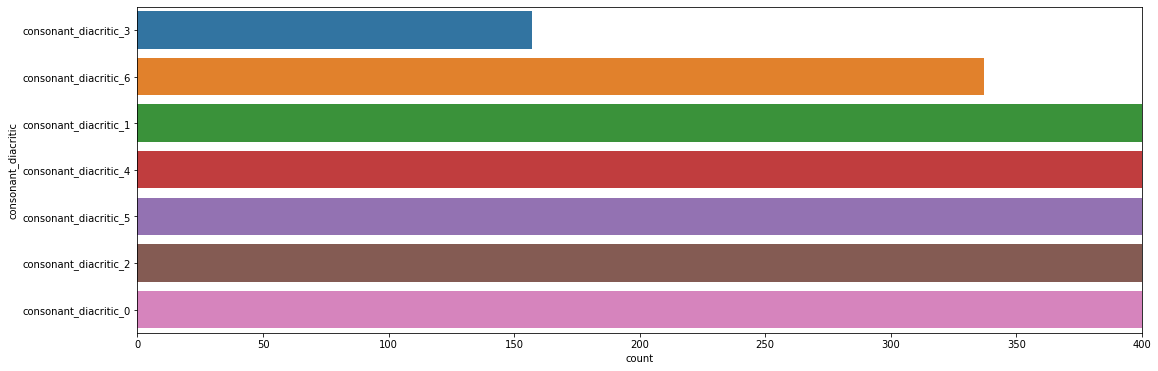

In [170]:
plt.figure(1,figsize=(18,6))
sns.countplot(y='consonant_diacritic',data=df,order=df['consonant_diacritic'].value_counts().sort_values().index)
plt.xlim(0,400)

In [0]:
df['category']=df['grapheme_root']+'/'+df['vowel_diacritic']+'/'+df['consonant_diacritic']

In [140]:
df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,category
0,Train_0,grapheme_root_15,volwel_diacritic_9,consonant_diacritic_5,ক্ট্রো,grapheme_root_15/volwel_diacritic_9/consonant_...
1,Train_1,grapheme_root_159,volwel_diacritic_0,consonant_diacritic_0,হ,grapheme_root_159/volwel_diacritic_0/consonant...
2,Train_2,grapheme_root_22,volwel_diacritic_3,consonant_diacritic_5,খ্রী,grapheme_root_22/volwel_diacritic_3/consonant_...
3,Train_3,grapheme_root_53,volwel_diacritic_2,consonant_diacritic_2,র্টি,grapheme_root_53/volwel_diacritic_2/consonant_...
4,Train_4,grapheme_root_71,volwel_diacritic_9,consonant_diacritic_5,থ্রো,grapheme_root_71/volwel_diacritic_9/consonant_...


In [0]:
stats = ([0.0692], [0.2051])
data = (ImageList.from_df(df, path=path, folder='train', suffix='.png', 
        cols='image_id')
        .split_by_rand_pct(0.2)
        .label_from_df(cols=['category'],label_delim='/')
        .transform(get_transforms(do_flip=False,max_warp=0.1), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)


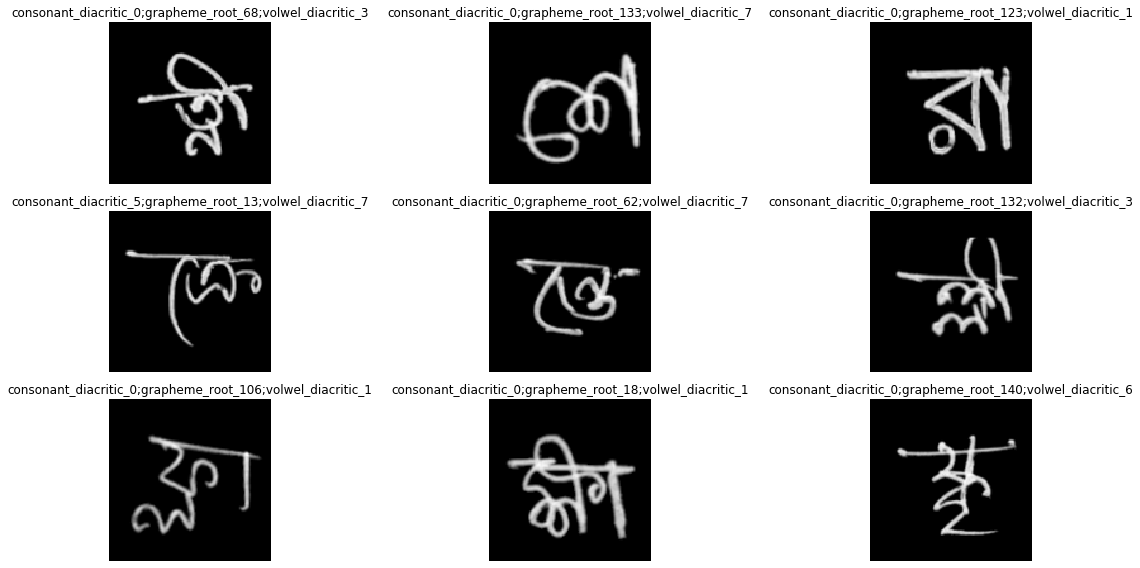

In [36]:
data.show_batch(rows=3,figsize=(16,8))

In [39]:
len(data.classes)

186

In [0]:
arch1 = models.resnet34

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch1, metrics=[acc_02, f_score]).to_fp16()

In [43]:
lr=0.01
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.055135,0.043129,0.986492,0.550538,01:52
1,0.038485,0.033677,0.988496,0.623644,01:51


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


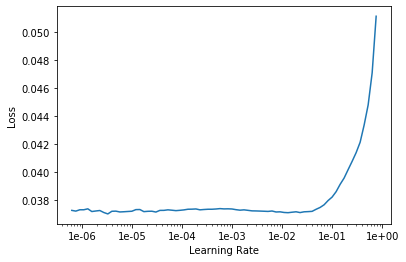

In [44]:
learn.lr_find()
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(5,slice(1e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.036396,0.032278,0.988864,0.636599,01:53
1,0.033843,0.029327,0.989413,0.668036,01:54
2,0.031415,0.027228,0.990034,0.690290,01:53
3,0.029917,0.026207,0.990360,0.701842,01:54
4,0.029163,0.026043,0.990385,0.704348,01:53


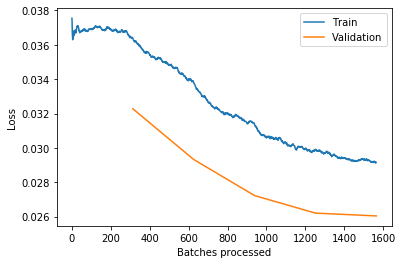

In [49]:
learn.recorder.plot_losses()

In [0]:
learn.save('model1')
#learn.export('grapheme.pkl')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


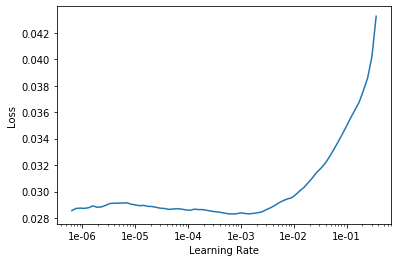

In [55]:
learn.load('model1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.022058,0.017077,0.993421,0.814667,01:59
1,0.014031,0.010629,0.995774,0.895686,01:59
2,0.009347,0.007169,0.997117,0.932343,01:59
3,0.006241,0.005700,0.997783,0.948601,01:59
4,0.004826,0.005365,0.997908,0.951697,01:59


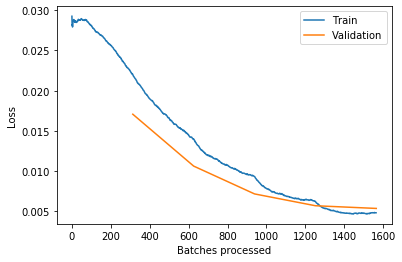

In [57]:
learn.recorder.plot_losses()

In [0]:
learn.save('model2')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


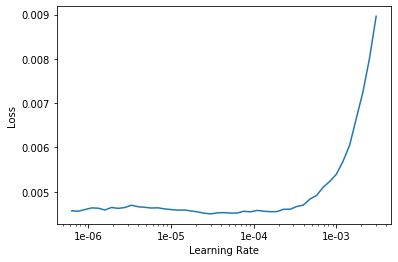

In [59]:
learn.load('model2')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [60]:
learn.fit_one_cycle(4, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.005596,0.006635,0.997527,0.940413,01:59
1,0.005376,0.005684,0.997900,0.950070,01:59
2,0.003515,0.005009,0.998181,0.956713,01:59
3,0.002532,0.004814,0.998323,0.958980,01:59


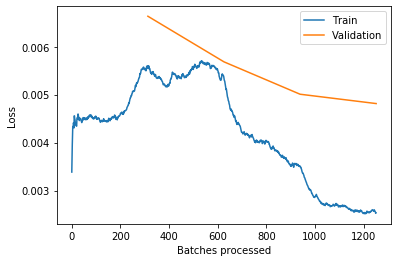

In [61]:
learn.recorder.plot_losses()

In [0]:
learn.export('grapheme956fbeta.pkl')

In [0]:
import cv2
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [0]:
HEIGHT = 137
WIDTH = 236
SIZE = 128

TRAIN = ['/content/test_image_data_3.parquet']

OUT_TRAIN = 'test3.zip'

In [0]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [109]:
x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
    for fname in TRAIN:
        df = pd.read_parquet(fname)
        #the input is inverted
        data = 255 - df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
        for idx in tqdm(range(len(df))):
            name = df.iloc[idx,0]
            #normalize each image by its max val
            img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
            img = crop_resize(img)
        
            x_tot.append((img/255.0).mean())
            x2_tot.append(((img/255.0)**2).mean()) 
            img = cv2.imencode('.png',img)[1]
            img_out.writestr(name + '.png', img)


In [67]:
#image stats
img_avr =  np.array(x_tot).mean()
img_std =  np.sqrt(np.array(x2_tot).mean() - img_avr**2)
print('mean:',img_avr, ', std:', img_std)

mean: 0.07458432266135621 , std: 0.22005462522751046


In [68]:
!unzip '/content/test.zip'

Archive:  /content/test.zip
 extracting: Test_0.png              
 extracting: Test_1.png              
 extracting: Test_2.png              


In [110]:
!unzip '/content/test3.zip'

Archive:  /content/test3.zip
 extracting: Test_9.png              
 extracting: Test_10.png             
 extracting: Test_11.png             


In [0]:
defaults.device = torch.device('cpu')

In [0]:
learnp = load_learner('/content/')

In [0]:
test_set=['/content/Test_0.png','/content/Test_1.png','/content/Test_2.png',
          '/content/Test_3.png','/content/Test_4.png','/content/Test_5.png',
          '/content/Test_6.png','/content/Test_7.png','/content/Test_8.png',
          '/content/Test_9.png','/content/Test_10.png','/content/Test_11.png'
          ]

prediction : consonant_diacritic_0;grapheme_root_19;volwel_diacritic_0


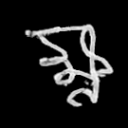

In [79]:
img2 = open_image(test_set[2])
pred_class,pred_idx,outputs = learn.predict(img2)
print("prediction : "+str(pred_class))
img2

prediction : consonant_diacritic_0;grapheme_root_93;volwel_diacritic_2


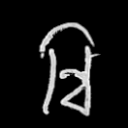

In [81]:
img1 = open_image(test_set[1])
pred_class,pred_idx,outputs = learn.predict(img1)
print("prediction : "+str(pred_class))
img1

prediction : consonant_diacritic_0;grapheme_root_3;volwel_diacritic_0


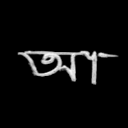

In [80]:
img0 = open_image(test_set[0])
pred_class,pred_idx,outputs = learn.predict(img0)
print("prediction : "+str(pred_class))
img0

['consonant_diacritic_0', 'grapheme_root_3', 'volwel_diacritic_0']
['consonant_diacritic_0', 'grapheme_root_93', 'volwel_diacritic_2']
['consonant_diacritic_0', 'grapheme_root_19', 'volwel_diacritic_0']
['consonant_diacritic_0', 'grapheme_root_115', 'volwel_diacritic_0']
['consonant_diacritic_0', 'grapheme_root_55', 'volwel_diacritic_4']
['consonant_diacritic_0', 'grapheme_root_115', 'volwel_diacritic_2']
['consonant_diacritic_5', 'volwel_diacritic_9']
['consonant_diacritic_0', 'grapheme_root_137', 'volwel_diacritic_7']
['consonant_diacritic_0', 'grapheme_root_119', 'volwel_diacritic_9']
['consonant_diacritic_0', 'grapheme_root_133', 'volwel_diacritic_10']
['volwel_diacritic_1']
['consonant_diacritic_0', 'grapheme_root_21', 'volwel_diacritic_2']


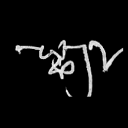

In [124]:
for i in range(12):
  img = open_image(test_set[i])
  pred_class,pred_idx,outputs = learn.predict(img)
  #img.show()
  #print("prediction : "+str(i+1)+" "+str(pred_class))
  print(str(pred_class).split(";"))
img = open_image(test_set[-2])
img